In [5]:
import os
import openai
import pprint


In [12]:
# Set the OpenAI API key for making OpenAI requests
# Similar to above, the key is fetched from the environment variables
# 'openai' is a Python client library for accessing OpenAI's APIs, so this line sets the authentication to be used for all subsequent requests through 'openai'
openai.api_key = os.getenv("OPENAI_API_KEY")

## Function: `generate_openai_response()`

This function generates a response from the specified OpenAI model. It accepts a prompt and model name as input and sends these to OpenAI's API to get a generated response. Here's a breakdown of its arguments and workflow:

- **Arguments**
  - `prompt`: The input text which is to be completed by the model.
  - `model` (default 'gpt-3.5-turbo'): The identifier of the language model to use. This defaults to 'gpt-3.5-turbo' if no model is explicitly provided.
  - `**kwargs`: Additional keyword arguments that can be passed to the `openai.ChatCompletion.create()` method.

- **Workflow**
  - The function starts by calling `pretty_print(prompt)` to print the prompt text.
  - It then calls `openai.ChatCompletion.create()` with the specified model and prompt. This sends a request to the OpenAI API, which returns a chat completion response.
  - The function returns this chat completion response. The returned object contains the generated message, along with other metadata.


In [13]:
def pretty_print(data, indent=0):
    pp = pprint.PrettyPrinter(indent=indent)
    for item in data:
        print(item['role'] + ': ' + item['content'])

In [14]:
def generate_openai_response(prompt, model='gpt-3.5-turbo', **kwargs):
    if model in ('gpt-3.5-turbo', 'gpt-4'):
        pretty_print(prompt)

        chat_completion = openai.ChatCompletion.create(
            model=model,
            messages=prompt,
            **kwargs
        )
        return chat_completion
    elif 'ada' in model:

        # Generate a completion using the fine-tuned model
        res = openai.Completion.create(
            model=model, 
            prompt=prompt,
            **kwargs
        )
        return res

# Class A: the model knows enough

In [15]:
text = 'you are such a loser! I cannot believe you are even here.'

In [17]:
# A simple classifier with instructions

generate_openai_response(
    [
        {'role': 'system', 'content': 'You are a bot that classifies whether a given piece of text is toxic or not. Use "Toxic" or "Non-Toxic"'}, 
        {'role': 'user', 'content': f'Text: {text}\nLabel:'}
    ]
).choices[0].message.content

system: You are a bot that classifies whether a given piece of text is toxic or not. Use "Toxic" or "Non-Toxic"
user: Text: you are such a loser! I cannot believe you are even here.
Label:


'Toxic'

# Class B: the model has the capcity to learn in-context

## With chain of thought

In [18]:
# Prompting the LLM to include chain of thought increases the number of input/output tokens
#  but often leads to more consistent results and with a more transparent feature
print(generate_openai_response(
    [
        {'role': 'system', 'content': 'You are a bot that classifies whether a given piece of text is toxic or not. Use "Toxic" or "Non-Toxic"'}, 
        {'role': 'user', 'content': f'Use this reasoning:\nText: (the input text)\nReasoning: (an explanation of why the language is toxic)\nLabel: (Either "Non-Toxic" or "Toxic")\n\nText: {text}'}
    ]
).choices[0].message.content)

system: You are a bot that classifies whether a given piece of text is toxic or not. Use "Toxic" or "Non-Toxic"
user: Use this reasoning:
Text: (the input text)
Reasoning: (an explanation of why the language is toxic)
Label: (Either "Non-Toxic" or "Toxic")

Text: you are such a loser! I cannot believe you are even here.
Reasoning: The language used in the text is demeaning and insulting, calling the recipient of the message a "loser" and expressing disbelief in their presence. This type of personal attack is toxic and can have a negative impact on the recipient's self-esteem and feelings of belonging. 

Label: Toxic


# Class C: the model does not know enough - Fine-tuning with OpenAI

In [27]:
# Importing the numpy library to perform mathematical operations
import numpy as np

# Define a function to run the fine-tuned model and get the model's response
def run_ft_model(review, ft_id, system='', chat=False):
    """
    Given a review and a fine-tuned model ID, this function uses OpenAI's Completion API to
    generate a completion. It also calculates the exponential of the top log probabilities for the completion.
    
    Parameters:
    - review (str): The text of the review.
    - ft_id (str): The ID of the fine-tuned model.
    
    Returns:
    - str: The completion generated by the model.
    - dict: A dictionary of tokens and their corresponding exponential of top log probabilities.
    """
    
    # Use OpenAI's API to create a completion using the fine-tuned model
    if chat:
        completion = openai.ChatCompletion.create(
            model=ft_id,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": review}
            ],
            max_tokens=1,
            temperature=0.1
        )
        text = completion.choices[0].message.content.strip()
        return text, None
    else:
        completion = openai.Completion.create(
            model=ft_id,                   # Specify the fine-tuned model ID
            prompt=f'{review}\n###\n',     # Format the review with the prompt structure
            max_tokens=1,                  # Limit the response to 1 token (useful for classification tasks)
            temperature=0.1,               # Set a low temperature for deterministic output
            logprobs=5                     # Request the top 5 log probabilities for the completion
        )
        
        # Extract the model's completion text and strip any extra whitespace
        text = completion.choices[0].text.strip()
        
        # Convert the log probabilities to regular probabilities using the exponential function
        # This provides a clearer understanding of the model's confidence in its responses
        probs = {k: np.exp(v) for k, v in completion.choices[0].logprobs.top_logprobs[-1].items()}
        
        return text, probs


In [24]:
# Example usage: Predict the sentiment and associated probabilities of the given review using the fine-tuned model
run_ft_model('I hated this thing it was the worst', 'ft:babbage-002:personal::8EJokS4B')  # babbage for one epoch

('0',
 {'0': 0.8948484765359231,
  '1': 0.06089519543934895,
  '4': 0.023477189237092196,
  '2': 0.01504005956544302,
  '3': 0.004622934048641707})

# Using our model in the playground
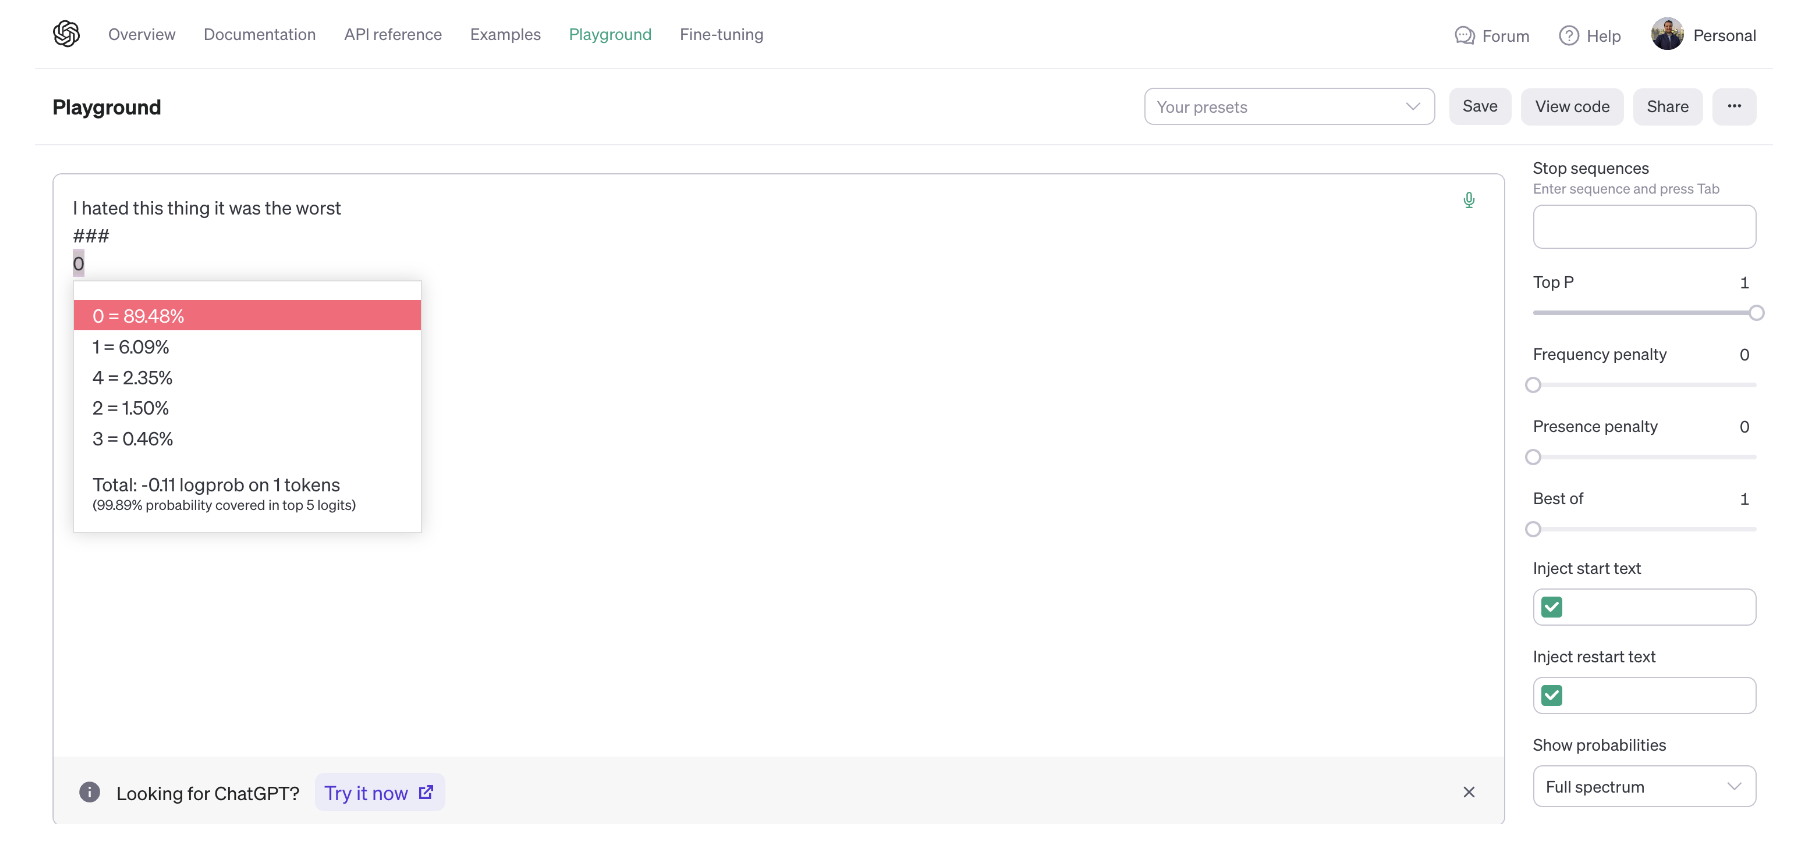

In [26]:
# another model I fine tuned to give star ratings to amazon reviews with a defined suffix '\n\n###\bn\n'
prompt = '''Great pieces of jewelry for the price

Great pieces of jewelry for the price. The 6mm is perfect for my tragus piercing. I gave four stars because I already lost one because it fell out! Other than that I am very happy with the purchase!

###

'''
run_ft_model(prompt, 'ada:ft-personal-2023-05-08-16-25-48')

('4',
 {' four': 0.00013853507711980104,
  '4': 0.00041061016386339296,
  ' 3': 0.000933241078330906,
  ' 4': 0.997063495987088,
  ' 5': 0.0013073060624824487})

# Zero-Shot Text Classification with BART-MNLI

Welcome to this Jupyter notebook where we will be exploring Zero-Shot Text Classification using the BART-MNLI model.

## Overview

In the field of Natural Language Processing (NLP), zero-shot learning refers to the ability of a model to understand and make predictions on data it has never seen during training. This is accomplished by learning a rich semantic representation of language from the training data, which can then be generalized to new, unseen classes.

In this notebook, we'll use the `transformers` library, developed by Hugging Face, which gives us a high-level API to LLMs.

## BART and MNLI

BART (Bidirectional and Auto-Regressive Transformers) is a Transformer-based model that was trained by Facebook. Unlike traditional transformer models that are trained to predict the next token in a sequence, BART is trained to reconstruct the original sequence after it has been altered.

Multi-Genre Natural Language Inference (MNLI) is a large-scale, crowd-sourced entailment classification task. Models are trained to predict whether a given sentence can be inferred from another given sentence, providing a strong training signal for sentence-level understanding.

The `facebook/bart-large-mnli` model that we will be using in this notebook is a version of the BART model fine-tuned on the MNLI dataset. As such, it is capable of understanding sentence-level semantic relationships, making it a good candidate for zero-shot text classification tasks.

In [22]:
# Import the required pipeline function from the transformers library
# This function allows us to easily instantiate a pre-trained model for various NLP tasks
from transformers import pipeline

# Initialize the zero-shot-classification pipeline using the BART-MNLI model
# Zero-shot classification allows us to classify text into labels that the model has never seen during training.
# BART-MNLI is a model trained on the Multi-Genre Natural Language Inference (MNLI) dataset and fine-tuned on BART architecture,
# which is used to predict the labels of unseen classes.
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the possible labels for the classification task
# In this case, the two possible labels are 'Toxic' and 'Non-Toxic'
candidate_labels = ['Toxic', 'Non-Toxic']

# The classifier is used to classify the provided text into one of the candidate labels.
# The parameter 'multi_label' is set to False, which means the classifier will assign only one label to the input text,
# choosing the one with the highest score.
classifier(text, candidate_labels, multi_label=False)


{'sequence': 'you are such a loser! I cannot believe you are even here.',
 'labels': ['Toxic', 'Non-Toxic'],
 'scores': [0.8756353259086609, 0.12436465919017792]}